In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from common.data_loader import load_images
from utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from config.common_path import get_encoded_csv_file
from generative_models.vae import VAE
from config import ExperimentConfig
from experiments.experiment import Experiment
from analysis.encode_decode import decode
from PIL import Image


%matplotlib inline


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
def cluster_and_decode_latent_vectors(num_clusters, latent_vectors, exp_config, 
                                      cluster_column_name="cluster_level_1"):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(latent_vectors)
    cluster_centers = kmeans.cluster_centers_
    tf.reset_default_graph()
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
                epoch=1,
                batch_size=exp_config.BATCH_SIZE,
                z_dim=exp_config.Z_DIM,
                dataset_name=exp_config.dataset_name,
                beta = exp_config.beta,
                num_units_in_layer=exp_config.num_units,
                log_dir=exp_config.LOG_PATH,
                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                result_dir=exp_config.PREDICTION_RESULTS_PATH
                   )
        # show network architecture
        #show_all_variables()
#         checkpoint_counter = model.load_from_checkpoint()
#         print("Check point counter", checkpoint_counter)

        z = np.zeros([len(cluster_centers) * num_clusters, exp_config.Z_DIM])

        for i in range(cluster_centers.shape[0]):
            z[i, :] = cluster_centers[i]

        #decoded_images = model.decode(z)
        decoded_images = decode(model, z, exp_config.BATCH_SIZE)
        return decoded_images, cluster_centers, cluster_labels

In [3]:
class ManualAnnotation:
    # All intervals are half open which is closed on lower bound and open on upper bound
    confidence_intervals = {"low_confidences_clusters": (0, 0.35),
                            "average_clusters": (0.35, 0.65),
                            "good_clusters": (0.65, 1)
                            }

    def __init__(self, label, confidence):
        self.label = label
        self.confidence = confidence

    def get_label(self):
        # TODO implement this for tuples with multiple element
        if self.confidence is tuple:
            for confidence_label, confidence_interval in ManualAnnotation.confidence_intervals.items():
                if confidence_interval[0] <= self.confidence[0] < confidence_interval[1]:
                    confidence_1 = confidence_label

            for confidence_label, confidence_interval in ManualAnnotation.confidence_intervals.items():
                if confidence_interval[0] <= self.confidence[1] < confidence_interval[1]:
                    confidence_2 = confidence_label

            return (confidence_1, confidence_2)
        for confidence_label, confidence_interval in ManualAnnotation.confidence_intervals.items():
            if confidence_interval[0] <= self.confidence < confidence_interval[1]:
                return confidence_label


class Cluster:
    def __init__(self,
                 cluster_id,
                 name,
                 cluster_details,
                 level=1,
                 manual_annotation=None):
        self.id = cluster_id
        self.name = name
        self.details = cluster_details
        self.level = level
        self.manual_annotation = manual_annotation
        self.next_level_clusters = ClusterGroup("Clusters_level_{}".format(level))


class ClusterGroup:
    def __init__(self,
                 name,
                 cluster_list=None,
                 manual_annotation=None):
        self.name = name,
        self.iter_index = 0
        self.cluster_list = cluster_list
        self.manual_annotation = manual_annotation

    def __iter__(self):
        return self

    def __next__(self):
        if self.iter_index < len(self.cluster_list):
            self.iter_index += 1
            return self.cluster_list[self.iter_index - 1]
        else:
            self.iter_index = 0
            raise StopIteration()

    def is_singleton(self):
        if len(self.cluster_list) == 1:
            return True
        else:
            return False

    def add_cluster(self, cluster):
        if self.cluster_list is None or len(self.cluster_list) == 0:
            self.cluster_list = [cluster]
        else:
            self.cluster_list.append(cluster)

    def get_cluster(self, cluster_num):
        for cluster in self.cluster_list:
            if cluster.id == cluster_num:
                return cluster


In [4]:
def display_cluster_center_images(decoded_images, image_filename):
    colormap = "Greys"
    fig = plt.figure()
    fig.tight_layout()
    num_cols = 4
    num_rows =  math.ceil(num_clusters / num_cols)
    fig.suptitle("Decoded Cluster Centers. \nClusterd the latent vectors of training set N_3={} z_dim={} run_id={}".format(N_3,
                                                                                                                           exp_config.Z_DIM,
                                                                                                                           run_id + 1) )
    for i in range(cluster_centers.shape[0]):
        ax = fig.add_subplot(3, num_cols, i + 1)
        ax.imshow(np.squeeze(decoded_images[i]), cmap=colormap)
    plt.savefig(image_filename,
                bbox="tight",
                pad_inches=0)

# Set experiment parameters

In [5]:
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 5
run_id = 2

ROOT_PATH = "/Users/sunilkumar/concept_learning_old/image_classification_supervised/"
exp_config = ExperimentConfig(ROOT_PATH, 4, Z_DIM, [N_1, N_2, N_3], num_val_samples=128)
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name

cluster_column_name="cluster_level_1"

# Read the latent vectors for train data

In [6]:
filename  = get_encoded_csv_file(N_2, N_3, Z_DIM, "train")
mean_col_names, sigma_col_names, z_col_names = get_latent_vector_column(Z_DIM)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=2 z_min=-4.1051106 z_max=4.276986
Latent vectors shape (59840, 5)


# Load the trained model

In [7]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=Z_DIM,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

W0701 19:00:21.337627 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:70: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 19:00:21.347736 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:89: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0701 19:00:21.348956 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/tensorflow_wrappers/layers.py:36: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0701 19:00:21.465738 140735495193472 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:150: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0701 19:00:21.496320 140735495193472 deprecation_wrapper.py:119

 [*] Reading checkpoints...
ckpt_name VAE.model-936
 [*] Success to read VAE.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0


# Load training images,  labels and manual annotations

In [8]:

manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
train_val_iterator, images, labels, manual_annotation_np = load_images(exp_config,
                                                                    "train",
                                                                    manual_annotation_file)
unique_labels = train_val_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Warning /Users/sunilkumar/concept_learning_old/image_classification_supervised/Exp_05_032_128_2/mnist/Split_1/VAE_mnist_64_05/analysis/manual_annotation_epoch_0.0.csv path does not exist. Creating random prior with uniform distribution
Number of epochs completed 1.0


/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


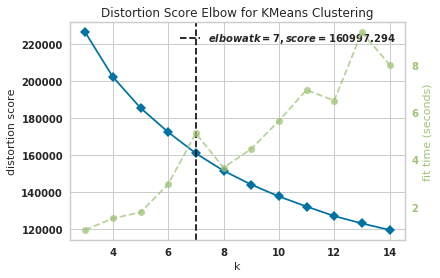

In [43]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [9]:
num_clusters = 7

# Cluster and decode latent vectors

# Display images corresponding to cluster center

In [10]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           "manual_annotation_epoch_{}.json".format(epochs_completed))
image_filename = exp_config.ANALYSIS_PATH + "cluster_centers_k_{}_{}.png".format(num_clusters, epochs_completed)
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and get manual annotation
    #TODO make this input from the user
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        cluster_column_name)
    display_cluster_center_images(decoded_images, image_filename)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [11]:
#manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the 
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [9,0,9,6,3,1,-1]
    manual_annotation_json["manual_confidence"] = [0.9,0.9,0.9,0.7,0.8,0.9,0]

    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

In [12]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [13]:
# Returns a filtered version of original dataframe with samples from only one cluster included
# @param:df Dataframe containing all samples
# @param:cluster_num Cluster number
def get_samples_for_cluster(df, cluster_num, cluster_column_name):
    _df = df[df[cluster_column_name] == cluster_num]
    return _df

In [14]:
from analysis import Cluster
from analysis import ClusterGroup
from collections import defaultdict

clustering_level = 1
"""
Create groups of clusters based on manual label given to each cluster. Different categories of cluster group are
1. impure
Contains impure clusters. impure cluster is a cluster where the cluster center have similarity with multiple labels,
each with different confidence
2. unknown
The user who annotated the label doesn't know the label, or it is an invalid data for the domain under consideration
3. similar_labels
There are multiple clusters in the cluster group all of which has similar label
4. good_clusters
There are multiple clusters all with different labels each with a different confidence level greater than a threshold
4. average_clusters
There are multiple clusters all with different labels each with a different confidence level around 0.5
5. low_confidence_clusters
There are multiple clusters all with different labels each with a different confidence level close to zero
"""
#TODO check how to do this with parameters to constructer
#cluster_groups_dict = defaultdict(ClusterGroup)
annotation_string = "pure_cluster:Cluster number: {}\nCluster center label:{}\n Confidence: {}"
def get_cluster_groups(manual_labels):
    cluster_groups_dict = dict()
    for cluster_num, cluster_center_label in enumerate(manual_labels):
        _df = get_samples_for_cluster(df, cluster_num, cluster_column_name)
        indices = np.where(df[cluster_column_name].values == cluster_num)
        cluster_details = {
            "cluster_centers":cluster_centers[cluster_num],
            "cluster_labels":cluster_labels,
            "indices":indices, # Indices of this cluster elements in parent dataframe
            "cluster_data_frame":_df,
            "whole_data_frame":df
           }
        if isinstance(cluster_center_label, tuple):
            #impure cluster
            #create an impure clusterGroup            
            manual_annotation = ManualAnnotation(cluster_center_label,manual_confidence[cluster_num])
            cluster= Cluster(cluster_id=cluster_num,
                             name="cluster_".format(cluster_num),
                             cluster_details=cluster_details,
                             level=1,
                            manual_annotation=manual_annotation)
            if "impure_cluster" in cluster_groups_dict.keys():
                cluster_groups_dict["impure_cluster"].add_cluster(cluster)
            else:
                cluster_groups_dict["impure_cluster"] = [cluster]
        elif cluster_center_label == -1:
            #unknown cluster
            cluster= Cluster(cluster_id=cluster_num, name="cluster_".format(cluster_num), cluster_details=cluster_details,level=1)
            if "unknown cluster" in cluster_groups_dict.keys():
                cluster_groups_dict["unknown cluster"].add_cluster(cluster)
            else:
                cluster_groups_dict["unknown cluster"] = [cluster]
            # unknown cluster
        else:
            # good/average/low confidence
            manual_annotation = ManualAnnotation(cluster_center_label, manual_confidence[cluster_num])
            #cluster_group_label = manual_annotation.get_label()
            cluster = Cluster(cluster_id=cluster_num,
                             name="cluster_".format(cluster_num),
                             cluster_details=cluster_details,
                             level=1,
                            manual_annotation=manual_annotation)
            cluster_group_label = manual_annotation.get_label()
            if cluster_group_label in cluster_groups_dict.keys():
                cluster_groups_dict[cluster_group_label].add_cluster( cluster)
            else:
                cluster_groups_dict[cluster_group_label] = ClusterGroup(cluster_group_label,[cluster])
    return cluster_groups_dict

In [15]:
cluster_group_dict = get_cluster_groups( manual_labels )

In [16]:
cluster_group_dict

{'good_clusters': <analysis.ClusterGroup at 0x14d2d24d0>,
 'unknown cluster': [<analysis.Cluster at 0x14d2c7210>]}

In [17]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


In [18]:
def plot_number_of_samples_vs_label(cluster_group, title_string):
    for cluster in cluster_group:
        cluster_num = cluster.id
        cluster_details = cluster.details
        _df = cluster_details["cluster_data_frame"]
        fig = plt.figure(figsize=(20, 8))
        #fig.tight_layout()
        plt.title(title_string.format(cluster_group_name, cluster_num),fontsize=22)
        plt.xlabel("Label")
        plt.ylabel("Number of samples")
        number_of_samples_for_label = get_pmf_y_given_z(_df, "label", exp_config.Z_DIM, normalized=False)
        plt.bar(x=number_of_samples_for_label.index.values + 0.5,
                height=number_of_samples_for_label,
                width=0.8, align="center")
        plt.text(0.22, 0.84, "Manual Label : {},{}".format(manual_labels[cluster_num], manual_confidence[cluster_num]),
                bbox=dict(facecolor='red', alpha=0.5),
                transform=fig.transFigure)
        plt.xticks(number_of_samples_for_label.index.values + 0.5, number_of_samples_for_label.index.values)
        plt.ylim(0, max(number_of_samples_for_label) * 1.1) 
        plt.grid(which="major", axis="x")

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


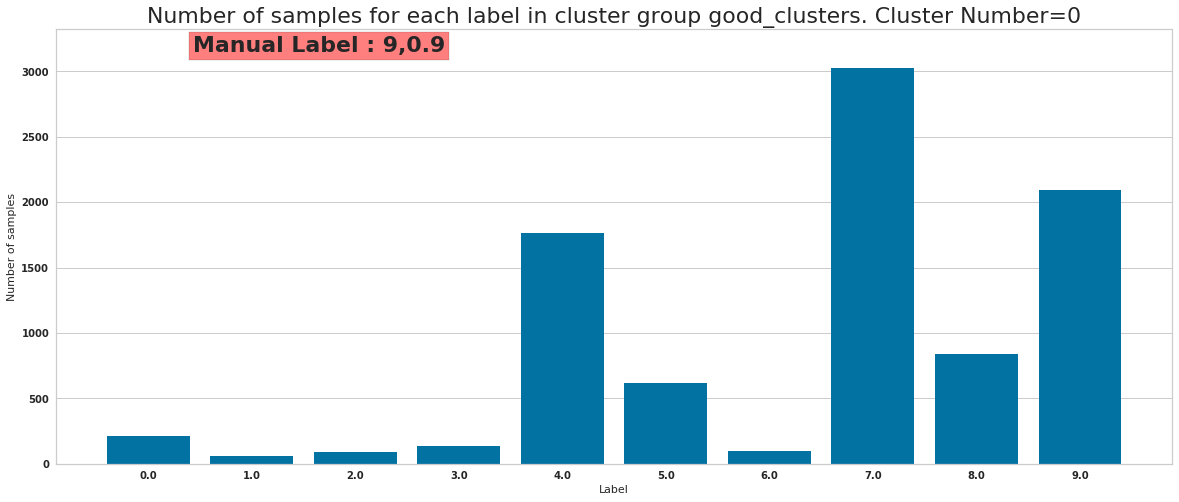

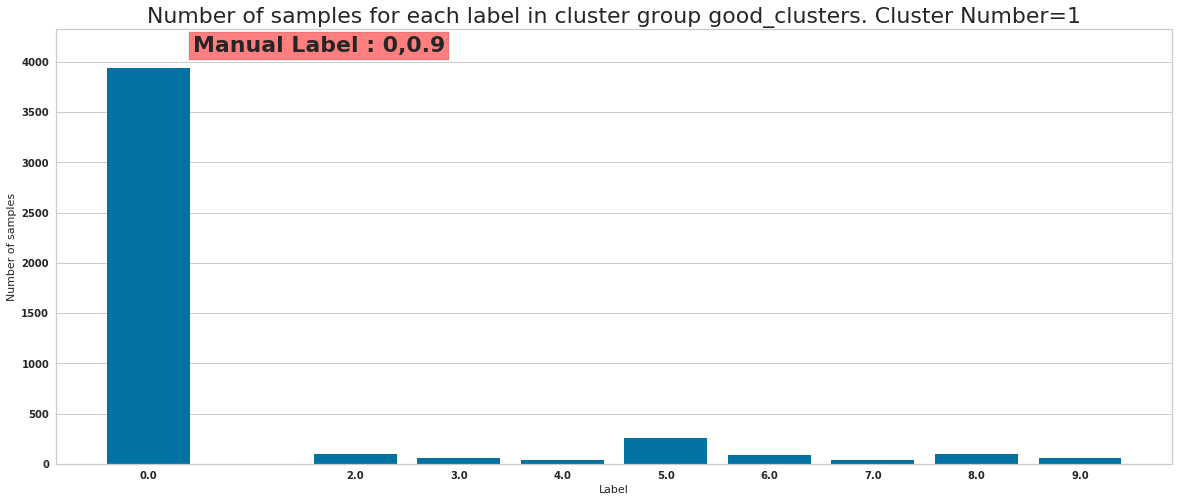

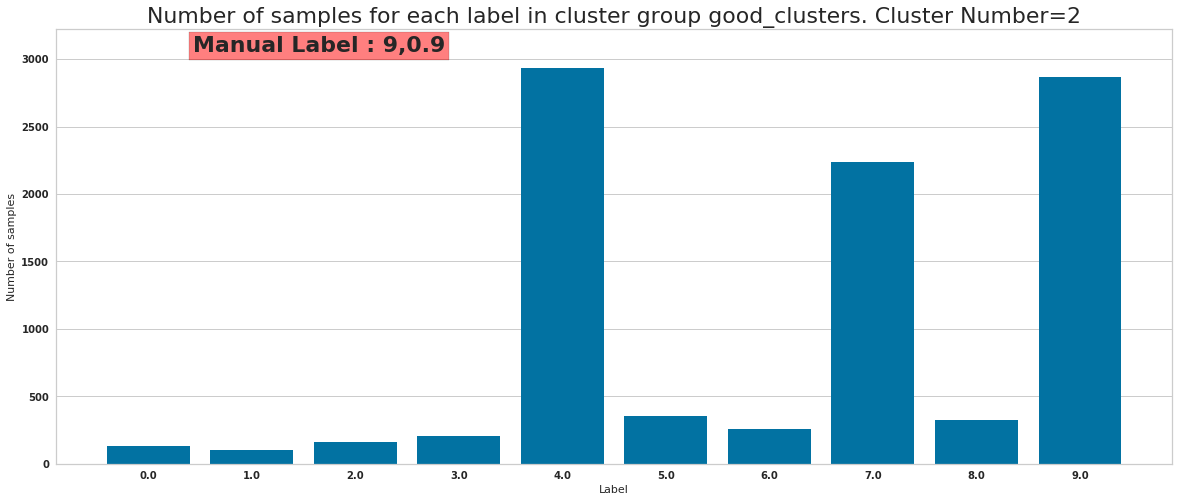

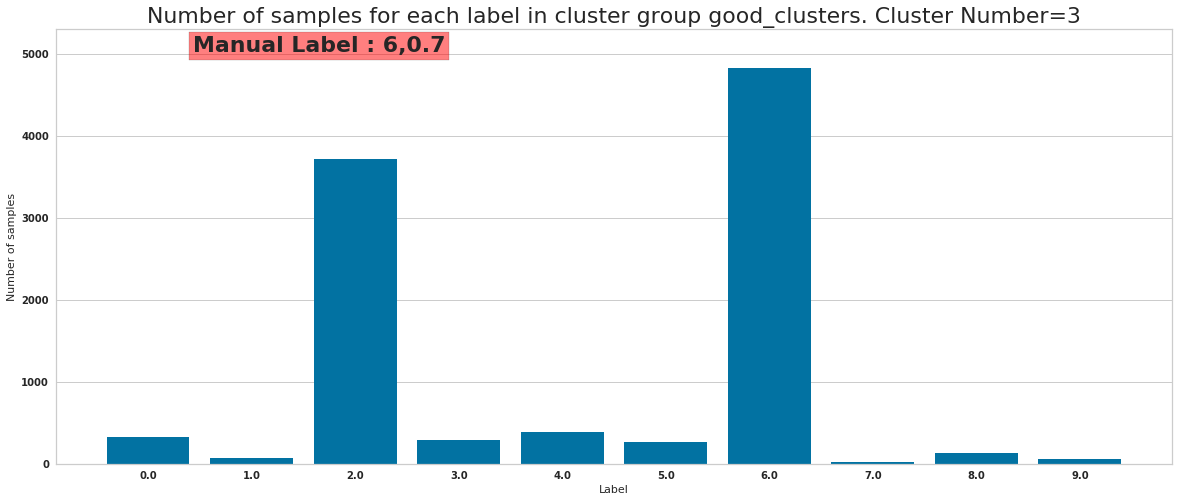

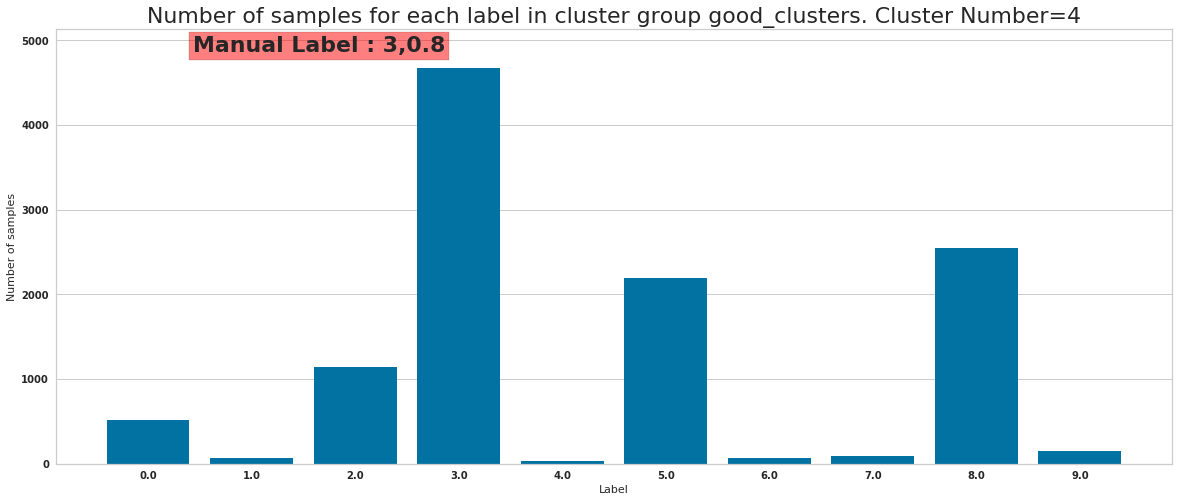

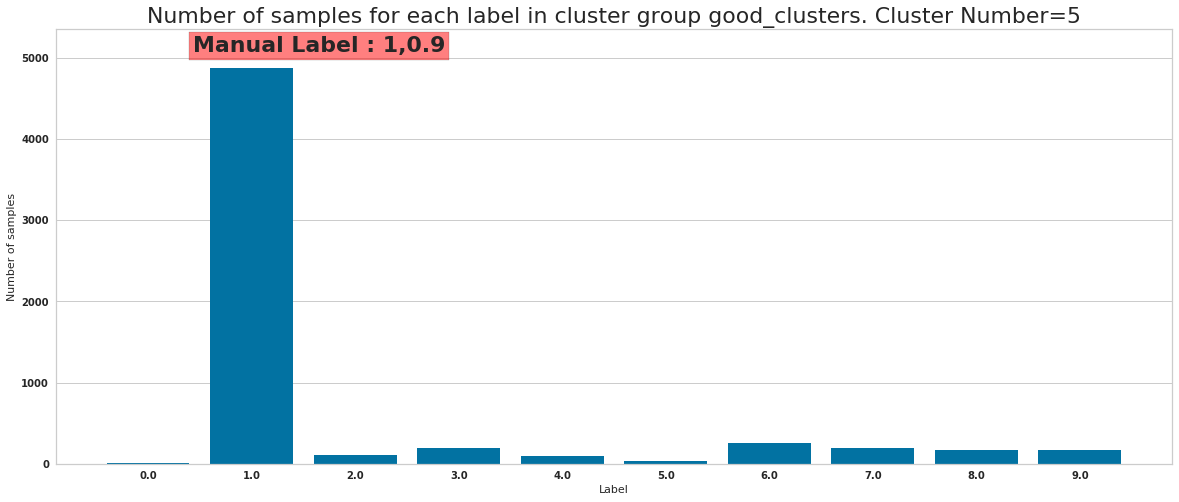

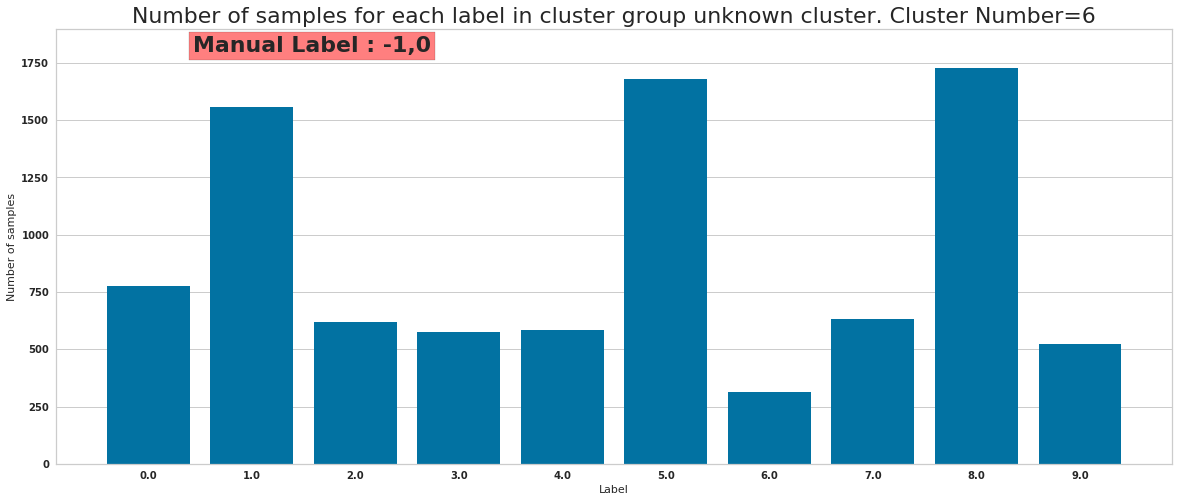

In [19]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )
                                   
    # plot_number_of_samples_vs_label(pure_clusters,
    #                                 "Number of samples for each label in {} cluster. Cluster Number={}".format(cluster_name,
    #                                                                                                            cluster_num))

# For each sample, compute distance from respective cluster center

In [20]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)

In [21]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,cluster_centers[cluster_num],
                                                                                         z_col_names),
                                                                       axis=1)


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Save the dataframe with manual annotations

In [22]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(N_2, N_3, Z_DIM, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(N_2, N_3, Z_DIM, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([ 8938.,  4650.,     0.,  9569.,     0., 10106., 11501.,     0.,
         6095.,  8981.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

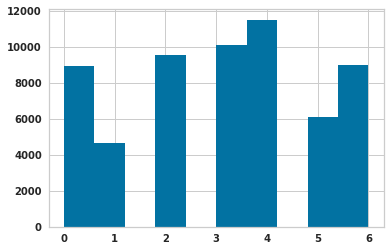

In [23]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [24]:
def plot_distance_distribution(clusters):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 22}
    legend_string = "Cluster Number={} Label={}"
    matplotlib.rc('font', **font)
    plt.figure(figsize=(20, 8))
    for cluster_num in clusters:
        _df = get_samples_for_cluster(df, cluster_num, cluster_column_name)
        col_name = "distance_{}".format(cluster_num)
        v, b = np.histogram(_df[col_name].values, bins=20, normed=False)
        v = v/np.sum(v)
        plt.plot(b[:-1], v, label = legend_string.format(cluster_num, manual_labels[cluster_num]))
        plt.xlabel("Distance from cluster center")
        plt.ylabel("Number of samples")
        plt.title("Distribution of distance from cluster center")
    plt.legend()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()


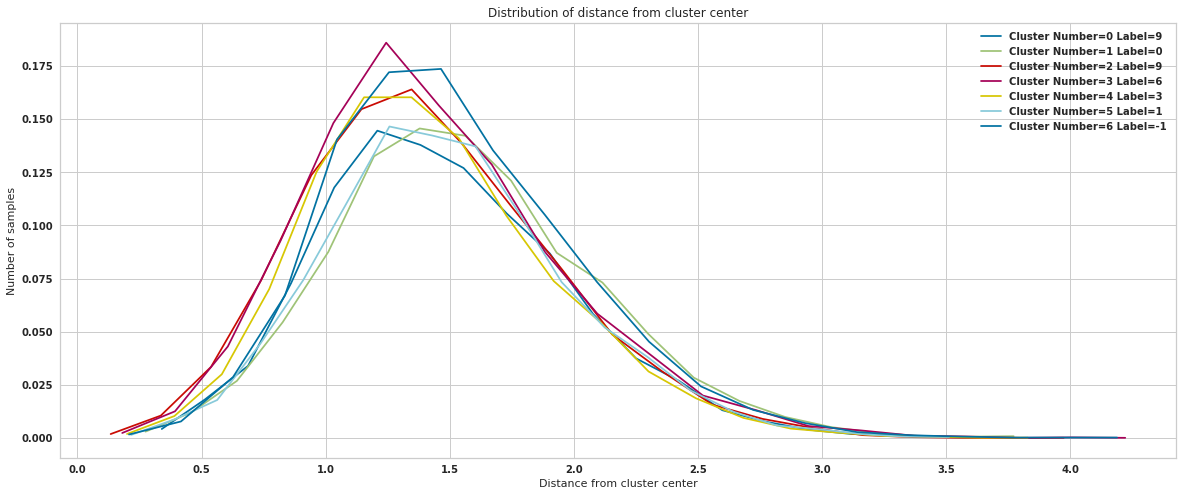

In [26]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

In [28]:
def get_cluster(cluster_num):
    #TODO review this with Prathyush
    for cluster_group_name, cluster_group in cluster_group_dict.items():
        cluster = cluster_group.get_cluster(cluster_num)
        if cluster is not None:
            return cluster
        

In [33]:
#k=100
df["manual_annotation"] =  np.ones(df.shape[0]) * -1
df["manual_annotation_confidence"] = np.zeros(df.shape[0])
for i in range(num_clusters):
    annotate_cluster = i    
    distance_df = df["distance_{}".format(annotate_cluster)]
    #closest_k = np.argpartition(distance_df.values, k )[0:k]
    manual_label = manual_labels[annotate_cluster]
    if isinstance(manual_label,tuple) or isinstance(manual_label, list):
        #TODO write code to handle this
        pass
    if manual_label != -1 :
        print("Manual Label",manual_label)
        indices = np.where(cluster_labels == annotate_cluster)
        #print(indices.shape)
        df["manual_annotation"].iloc[indices] = manual_label
        cluster = get_cluster(annotate_cluster)
        print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
        num_correct = df[(df["manual_annotation"] == manual_label) & (df["label"] == manual_label)].shape[0]
        print("Num correct={}".format(num_correct))

        percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
        print("Cluster {} Manual Label {} Percentage correct {}".format(i,manual_label,percentage_correct))
        # TODO changge this to set the confidence based on distance
        dist = distance_df.iloc[indices]
        df["manual_annotation_confidence"].iloc[indices] = np.exp(-0.5 * dist)
    else:
        #TODO write code for unkown
        pass
    print("********************************")

Manual Label 9
(8938, 26) (8938, 17)
Num correct=2094
Cluster 0 Manual Label 9 Percentage correct 23.428059968673082
********************************
Manual Label 0
(4650, 26) (4650, 17)
Num correct=3934
Cluster 1 Manual Label 0 Percentage correct 84.60215053763442
********************************
Manual Label 9
(18507, 26) (9569, 17)
Num correct=4962
Cluster 2 Manual Label 9 Percentage correct 26.811476738531365
********************************
Manual Label 6
(10106, 26) (10106, 17)
Num correct=4825
Cluster 3 Manual Label 6 Percentage correct 47.74391450623392
********************************
Manual Label 3
(11501, 26) (11501, 17)
Num correct=4668
Cluster 4 Manual Label 3 Percentage correct 40.58777497608904
********************************
Manual Label 1
(6095, 26) (6095, 17)
Num correct=4867
Cluster 5 Manual Label 1 Percentage correct 79.85233798195242
********************************
********************************


In [34]:
def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
K = 2
def get_distance(confidence):
    return -K * log(confidence)
def get_confidence(distance):
    return np.exp(-distance/K)

Text(0,0.5,'Percentage Correct')

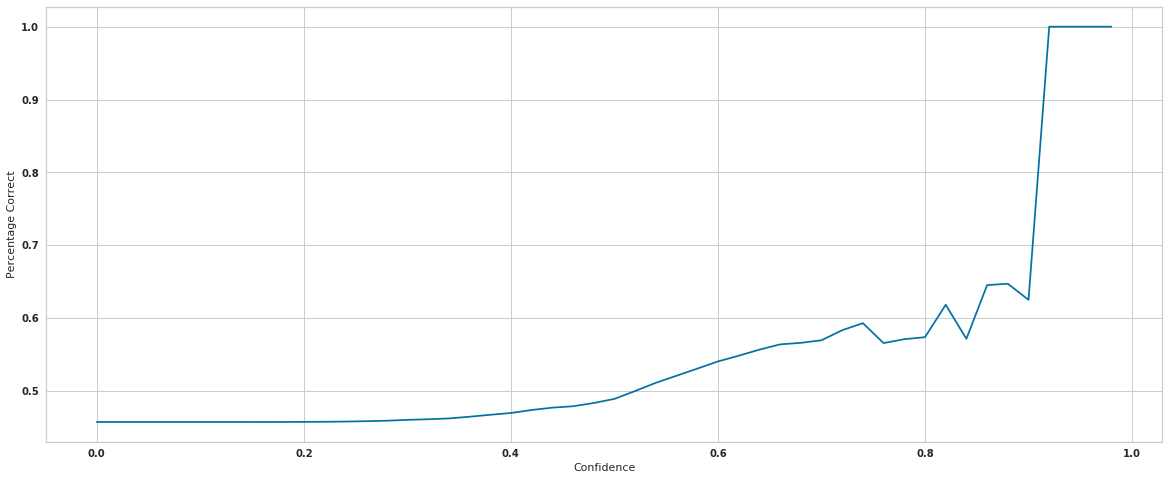

In [35]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

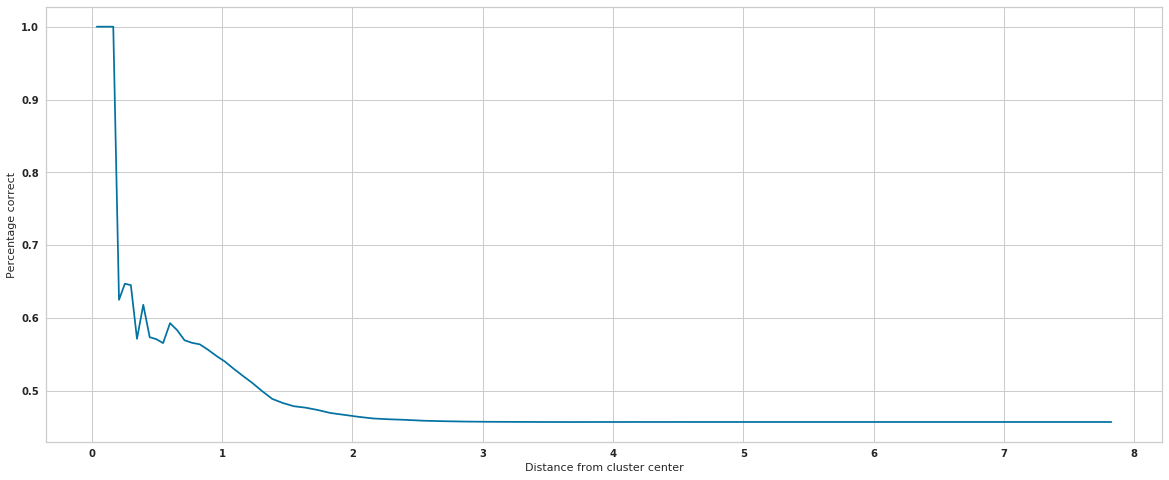

In [36]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [37]:
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

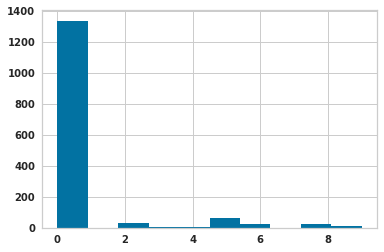

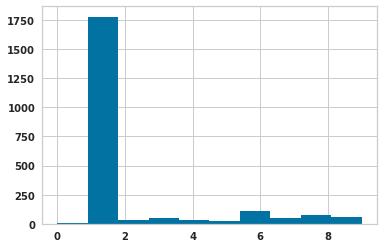

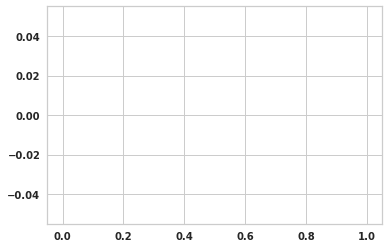

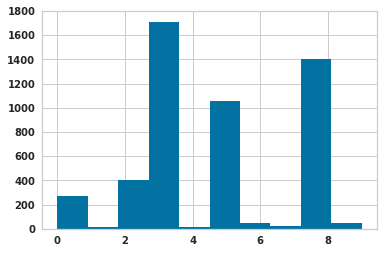

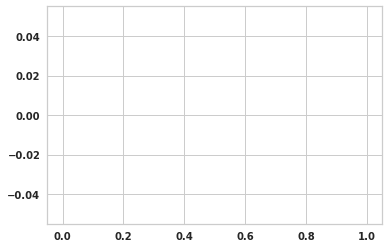

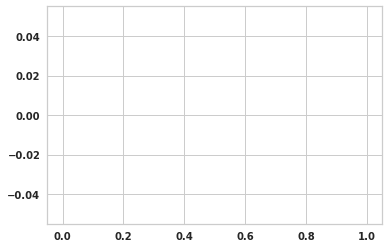

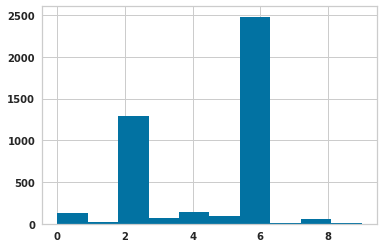

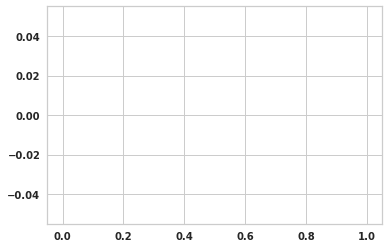

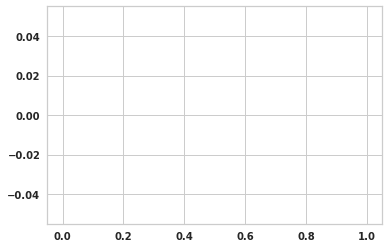

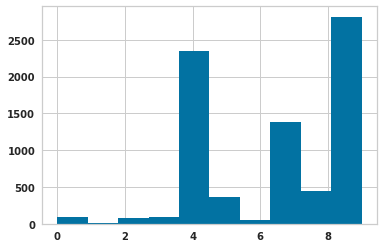

In [39]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()